## Import libraries

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import numpy as np
import pandas as pd
from time import sleep
import pickle

from PIL import Image, ImageDraw
from IPython.core.display import HTML

import cognitive_face as CF
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials

## This notebook uses Face API Service API provided by Microsoft
You first need to own Azure subscription and then follow bellow described steps. <font color='red'>*Below text fragment is copied from EDX course "Introduction to Artificial Intelligence (AI)".*</font>

### Create a Face API Service
To provision a Computer Vision API service in your Azure subscription, Follow these steps:

1. Open another browser tab and navigate to https://portal.azure.com.
2. Sign in using your Microsoft account.
3. Click **+ New**, and in the **AI + Cognitive Services** category, click **See all**.
4. In the list of cognitive services, click **Face**.
5. In the **Face** blade, click **Create**.
6. In the **Create** blade, enter the following details, and then click **Create**
  * **Name**: A unique name for your service.
  * **Subscription**: Your Azure subscription.
  * **Location**: Choose the Azure datacenter location where you want to host your service.
  * **Pricing tier**: Choose the F0 pricing tier.
  * **Resource Group**: Choose the existing resource group you created in the previous lab (or create a new one if you didn't complete the previous lab)
  * Read the notice about the use of your data, and select the checkbox.
7. Wait for the service to be created.
8. When deployment is complete, click **All Resources** and then click your Face service to open its blade.
9. In the blade for your Face service, copy the *full* **Endpoint** URL (including the *https* prefix and */face/v1.0/* path), and paste it into the **faceURI** variable assignment value in the cell below. <font color='red'>You also need to paste **Endpoint** into **faceEndpoint** variable.</font>
10. In the blade for your Face service, click **Keys** and then copy **Key 1** to the clipboard and paste it into the **faceKey** variable assignment value in the cell below. 
11. Run the cell below to assign the variables.

In [52]:
faceEndpoint = ''
faceURI = ''
faceKey = ''

### Once provided credentials they can be deleted from notebook after running below block.
Below block either dumps credentials to pickle file or load them from it.

In [53]:
if not os.path.isdir("pickles"):
     os.mkdir("pickles")
           
        
if os.path.isfile("pickles/faceKey.pkl"):
    
    with open('pickles/faceEndpoint.pkl', 'rb') as f:
        faceEndpoint = pickle.load(f)
    with open('pickles/faceURI.pkl', 'rb') as f:
        faceURI = pickle.load(f)
    with open('pickles/faceKey.pkl', 'rb') as f:
        faceKey = pickle.load(f)
    print("Credentials loaded from pickle")
    
else:
    
    if faceKey is None or faceKey == "":
        print("No faceKey provided! Service currently not available")
    else:
        with open('pickles/faceEndpoint.pkl', 'wb') as f:
            pickle.dump(faceEndpoint, f)
        with open('pickles/faceURI.pkl', 'wb') as f:
            pickle.dump(faceURI, f)
        with open('pickles/faceKey.pkl', 'wb') as f:
            pickle.dump(faceKey, f)
            
        print("Credentials written as pickle")

Credentials loaded from pickle


## Authenticate in two ways
Link to mentioned guide: https://docs.microsoft.com/pl-pl/azure/cognitive-services/face/quickstarts/python-sdk#authenticate-the-client

In [54]:
# Set URI and Key using SDK
CF.BaseUrl.set(faceURI)
CF.Key.set(faceKey)

# Authenticate in a different way (from online guide)
face_client = FaceClient(faceEndpoint, CognitiveServicesCredentials(faceKey))

# 1. Define needed functions

### Function to <u>only display</u> detected faces on image they come from

In [25]:
def mark_faces(img_, result):
    img = img_.copy()
    # Add rectangles for each face found
    color="blue"
    if result is not None:
        draw = ImageDraw.Draw(img) 
        for currFace in result:
            faceRectangle = currFace.face_rectangle
            left = faceRectangle.left
            top = faceRectangle.top
            width = faceRectangle.width
            height = faceRectangle.height
            draw.line([(left,top),(left+width,top)],fill=color, width=5)
            draw.line([(left+width,top),(left+width,top+height)],fill=color , width=5)
            draw.line([(left+width,top+height),(left, top+height)],fill=color , width=5)
            draw.line([(left,top+height),(left, top)],fill=color , width=5)

    # show the image
    plt.figure(figsize=(6,6))
    imshow(img)

### API function to <u>return</u> detected faces in <u>row format</u>, from an image provided using its <u>url</u>

In [26]:
def detect_faces_url(img_url):
    
    # Detect faces
    result = face_client.face.detect_with_url(img_url)
    
    # Download the image
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    
    # Draw rectangle around found faces
    mark_faces(img, result)
    
    return {"result" : result, "img" : img}

### API function to <u>return</u> detected faces in <u>row format</u>, from an image <u>stored locally</u>

In [27]:
def detect_faces_local(img_source):
    
    # Read image
    img = Image.open(img_source)
         
    # Detect faces
    result = face_client.face.detect_with_stream(open(img_source, 'r+b'))
    
    # Draw rectangle around found faces
    mark_faces(img, result)
    
    return {"result" : result, "img" : img}

### Function to crop faces from chosen images
Returns firstly list of face-images in PILLOW format and secondly list of faces ID (ID's are stored on Microsoft Service for 24 hours and are later used to compare faces).

In [28]:
def crop_faces(list_):

    face_image_list = []
    face_id_list = []
    
    for result in list_:
        for face in result['result']:

            face_id_list.append(face.face_id)
            
            rectangle = face.face_rectangle
            left = rectangle.left
            top = rectangle.top
            right = rectangle.left + rectangle.width
            bottom = rectangle.top + rectangle.height

            face_image_list.append(result['img'].crop((left, top, right, bottom)).resize((100,100)))

    # Display cropped faces horizontally 
    fig = plt.figure(figsize=(8,8))
    for i in range(len(face_image_list)):
        fig.add_subplot(1, len(face_image_list), i+1)
        imshow(face_image_list[i])
        plt.axis('off')
        
    # Return 2 lists
    return {"image_list" : face_image_list, "id_list" : face_id_list}

## Function to create a correlation matrix between images
A single element tells the `confidence level` for images from corresponding row and column, if they belong to the same person.

**This step is resourse consuming!**

In [29]:
def calculate_matrix(faces):
    
    corr_ = np.zeros((len(faces), len(faces)))

    for i in range(len(faces)):
        for j in range(len(faces)):
            corr_[i][j] = CF.face.verify(faces[i], faces[j])['confidence']
            #sleep(1)"
    return corr_

### Function to print correlation matrix

In [30]:
# Help function to convert from links to html tags
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'


def display_matrix(corr, cropped):
    
    corr2 = pd.DataFrame(corr.copy())
    
    if not os.path.isdir("cropped"):
        os.mkdir("cropped")

    # Save cropped faces locally as images
    links_list = []
    for image, id_ in zip(cropped['image_list'], cropped['id_list']): 
        link = "cropped/{}.jpg".format(id_)
        image.save(link, "JPEG")
        links_list.append(path_to_image_html(link))

    
    # Put images with html tags as indexes and columns
    corr2.index = links_list
    corr2.columns = links_list

    # Display matrix as html-formatted pandas DataFrame
    pd.set_option('display.max_colwidth', -1)
    display(HTML(corr2.to_html(escape=False)))

# 2. Process images

## Detect faces on images (raw)
This time images are stored locally.

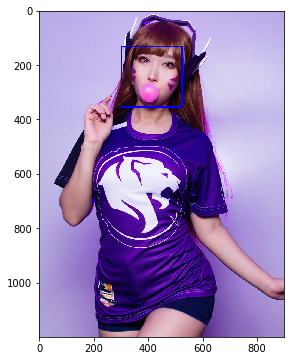

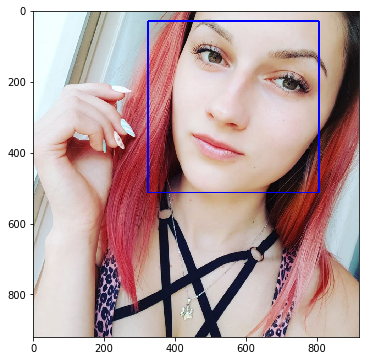

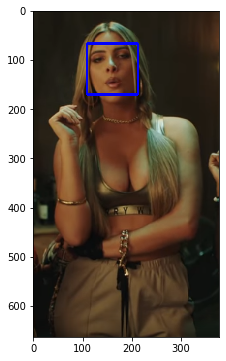

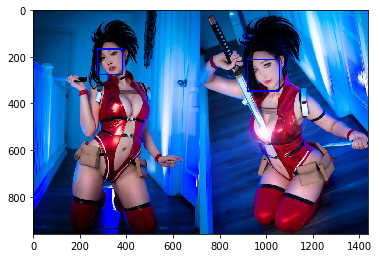

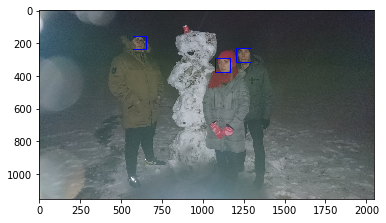

In [31]:
result_1 = detect_faces_local('images_1/1.jpg')
result_2 = detect_faces_local('images_1/2.bmp')
result_3 = detect_faces_local('images_1/3.bmp')
result_4 = detect_faces_local('images_1/4.jpg')
result_5 = detect_faces_local('images_1/5.jpg')

## Crop faces from images

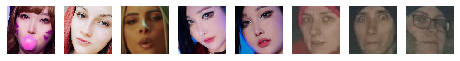

In [32]:
cropped = crop_faces([result_1, result_2, result_3, result_4, result_5])

## Calculate correlation matrix between faces

In [33]:
corr = calculate_matrix(cropped['id_list'])

## Print correlation matrix

In [34]:
display_matrix(corr, cropped)

,,,,,,,,
,1.00000,0.09742,0.08510,0.44058,0.56445,0.08271,0.09341,0.09308
,0.09742,1.00000,0.07805,0.12883,0.13810,0.26800,0.08051,0.08837
,0.08510,0.07805,1.00000,0.09037,0.08972,0.08930,0.09077,0.08728
,0.44058,0.12883,0.09037,1.00000,0.75101,0.08751,0.09113,0.09089
,0.56445,0.13810,0.08972,0.75101,1.00000,0.08713,0.08543,0.08843
,0.08271,0.26800,0.08930,0.08751,0.08713,1.00000,0.32658,0.17870
,0.09341,0.08051,0.09077,0.09113,0.08543,0.32658,1.00000,0.22410
,0.09308,0.08837,0.08728,0.09089,0.08843,0.17870,0.22410,1.00000


# Another batch of images

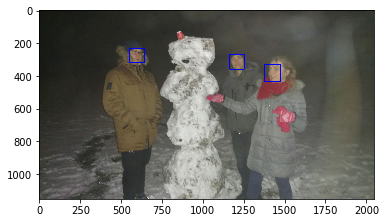

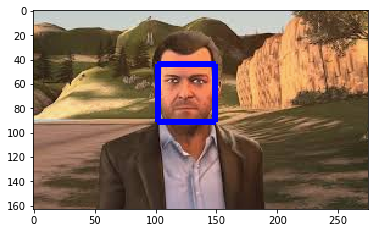

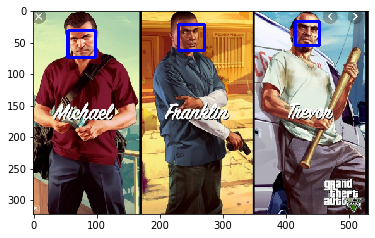

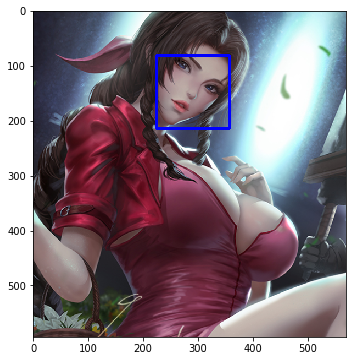

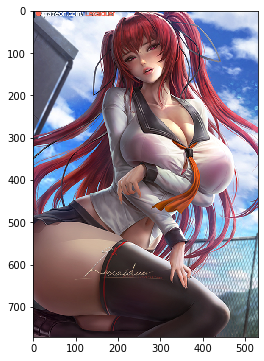

In [35]:
result_6 = detect_faces_local('images_2/1.jpg')
result_7 = detect_faces_local('images_2/2.bmp')
result_8 = detect_faces_local('images_2/3.bmp')
result_9 = detect_faces_local('images_2/4.bmp')
result_10 = detect_faces_local('images_2/5.bmp')

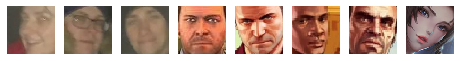

In [36]:
cropped_2 = crop_faces([result_6, result_7, result_8, result_9, result_10])

In [37]:
corr_2 = calculate_matrix(cropped_2['id_list'])

In [38]:
display_matrix(corr_2, cropped_2)

,,,,,,,,
,1.00000,0.09771,0.30859,0.08887,0.08485,0.08356,0.08122,0.10733
,0.09771,1.00000,0.22257,0.10811,0.09678,0.08613,0.08718,0.09904
,0.30859,0.22257,1.00000,0.08162,0.08409,0.08717,0.07859,0.09377
,0.08887,0.10811,0.08162,1.00000,0.48605,0.09193,0.10110,0.08800
,0.08485,0.09678,0.08409,0.48605,1.00000,0.13801,0.16290,0.09278
,0.08356,0.08613,0.08717,0.09193,0.13801,1.00000,0.25871,0.09617
,0.08122,0.08718,0.07859,0.10110,0.16290,0.25871,1.00000,0.08450
,0.10733,0.09904,0.09377,0.08800,0.09278,0.09617,0.08450,1.00000


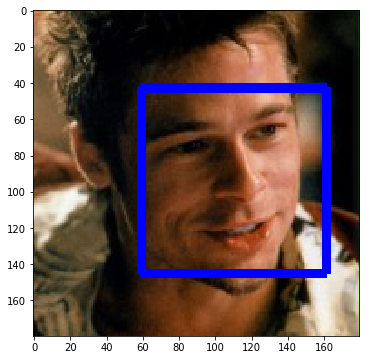

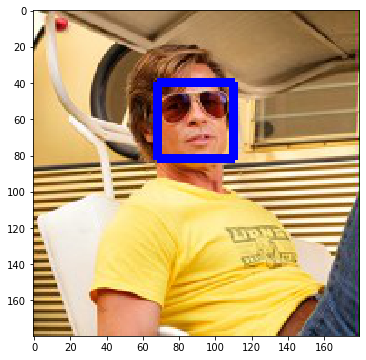

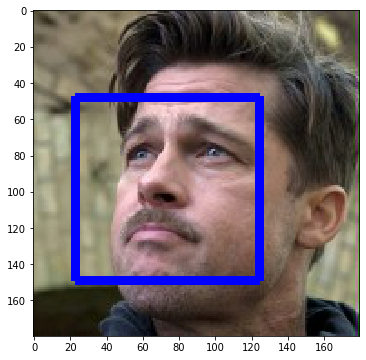

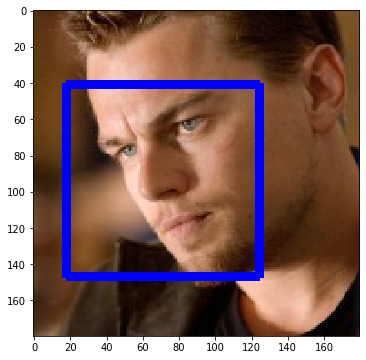

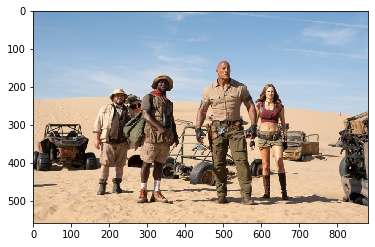

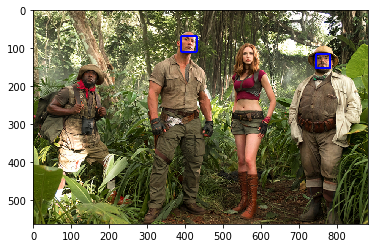

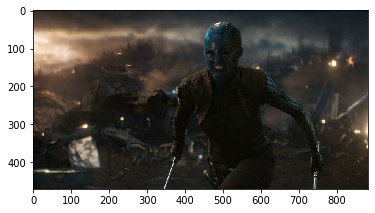

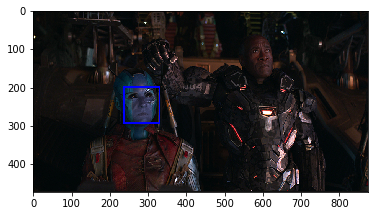

In [56]:
result_11 = detect_faces_local('images_3/1.jpg')
result_12 = detect_faces_local('images_3/2.jpg')
result_13 = detect_faces_local('images_3/3.jpg')
result_14 = detect_faces_local('images_3/4.jpg')
result_15 = detect_faces_local('images_4/1.jpg')
result_16 = detect_faces_local('images_4/2.jpg')
result_17 = detect_faces_local('images_4/3.jpg')
result_18 = detect_faces_local('images_4/4.jpg')

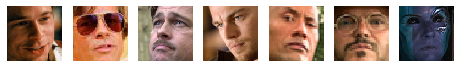

In [57]:
cropped_3 = crop_faces([result_11, result_12, result_13, result_14, result_15, result_16, result_17, result_18])

In [58]:
corr_3 = calculate_matrix(cropped_3['id_list'])

In [59]:
display_matrix(corr_3, cropped_3)

,,,,,,,
,1.00000,0.32726,0.37305,0.19264,0.07044,0.08421,0.07379
,0.32726,1.00000,0.22054,0.09955,0.09233,0.08529,0.08897
,0.37305,0.22054,1.00000,0.18313,0.07029,0.09866,0.06812
,0.19264,0.09955,0.18313,1.00000,0.08940,0.09649,0.08599
,0.07044,0.09233,0.07029,0.08940,1.00000,0.18303,0.09750
,0.08421,0.08529,0.09866,0.09649,0.18303,1.00000,0.09634
,0.07379,0.08897,0.06812,0.08599,0.09750,0.09634,1.00000
